In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
    saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

# No augmentation for validation/test
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

In [12]:
# Load datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('data/val', transform=val_transforms)
test_dataset = datasets.ImageFolder('data/test', transform=val_transforms)

In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 19998
Validation samples: 2500
Test samples: 2461


In [14]:
 # Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [15]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [16]:
# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [17]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Using device: {device}')
print(f'Training only final layer with {model.fc.in_features} output to 2')

Using device: cuda
Training only final layer with 512 output to 2


In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [19]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [20]:
# Training tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0

num_epochs = 10

In [21]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Saved best model with val_acc: {val_acc:.2f}%')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f' Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f' Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Saved best model with val_acc: 98.12%
Epoch [1/10]
 Train Loss: 0.1535, Train Acc: 94.08%
 Val Loss: 0.0578, Val Acc: 98.12%

Epoch [2/10]
 Train Loss: 0.1175, Train Acc: 95.13%
 Val Loss: 0.0557, Val Acc: 97.92%

Saved best model with val_acc: 98.56%
Epoch [3/10]
 Train Loss: 0.1069, Train Acc: 95.61%
 Val Loss: 0.0444, Val Acc: 98.56%

Epoch [4/10]
 Train Loss: 0.1165, Train Acc: 95.16%
 Val Loss: 0.0504, Val Acc: 97.92%

Epoch [5/10]
 Train Loss: 0.1133, Train Acc: 95.42%
 Val Loss: 0.0429, Val Acc: 98.48%

Epoch [6/10]
 Train Loss: 0.1062, Train Acc: 95.60%
 Val Loss: 0.0493, Val Acc: 98.16%

Saved best model with val_acc: 98.60%
Epoch [7/10]
 Train Loss: 0.1089, Train Acc: 95.65%
 Val Loss: 0.0440, Val Acc: 98.60%

Epoch [8/10]
 Train Loss: 0.1077, Train Acc: 95.69%
 Val Loss: 0.0487, Val Acc: 98.04%

Epoch [9/10]
 Train Loss: 0.1030, Train Acc: 95.89%
 Val Loss: 0.0465, Val Acc: 98.40%

Saved best model with val_acc: 98.64%
Epoch [10/10]
 Train Loss: 0.1080, Train Acc: 95.66%
 Va

In [22]:
# Load best model from Phase 1
model.load_state_dict(torch.load('best_model.pth'))

print("\n--- Starting Phase 2: Fine-tuning (Unfreezing layer4) ---")

# Unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# Update optimizer with lower learning rate (0.0001) for all trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

fine_tune_epochs = 10
total_epochs = num_epochs + fine_tune_epochs

for epoch in range(num_epochs, total_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Saved best model (fine-tuned) with val_acc: {val_acc:.2f}%')

    print(f'Epoch [{epoch+1}/{total_epochs}]')
    print(f' Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f' Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()


--- Starting Phase 2: Fine-tuning (Unfreezing layer4) ---
Epoch [11/20]
 Train Loss: 0.1141, Train Acc: 95.77%
 Val Loss: 0.0368, Val Acc: 98.56%

Epoch [12/20]
 Train Loss: 0.0624, Train Acc: 97.57%
 Val Loss: 0.0359, Val Acc: 98.44%

Saved best model (fine-tuned) with val_acc: 99.00%
Epoch [13/20]
 Train Loss: 0.0551, Train Acc: 97.75%
 Val Loss: 0.0240, Val Acc: 99.00%

Saved best model (fine-tuned) with val_acc: 99.20%
Epoch [14/20]
 Train Loss: 0.0473, Train Acc: 98.15%
 Val Loss: 0.0240, Val Acc: 99.20%

Epoch [15/20]
 Train Loss: 0.0428, Train Acc: 98.47%
 Val Loss: 0.0270, Val Acc: 98.96%

Epoch [16/20]
 Train Loss: 0.0403, Train Acc: 98.47%
 Val Loss: 0.0364, Val Acc: 98.64%

Epoch [17/20]
 Train Loss: 0.0306, Train Acc: 98.82%
 Val Loss: 0.0316, Val Acc: 98.60%

Epoch [18/20]
 Train Loss: 0.0256, Train Acc: 99.05%
 Val Loss: 0.0218, Val Acc: 99.16%

Epoch [19/20]
 Train Loss: 0.0226, Train Acc: 99.11%
 Val Loss: 0.0220, Val Acc: 99.00%

Epoch [20/20]
 Train Loss: 0.0210, Tra

In [23]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

correct_samples = []
incorrect_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Collect samples
        for i in range(images.size(0)):
            if len(correct_samples) < 10 and predicted[i] == labels[i]:
                correct_samples.append((images[i].cpu(), predicted[i].item(), labels[i].item()))
            elif len(incorrect_samples) < 10 and predicted[i] != labels[i]:
                incorrect_samples.append((images[i].cpu(), predicted[i].item(), labels[i].item()))

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.07%


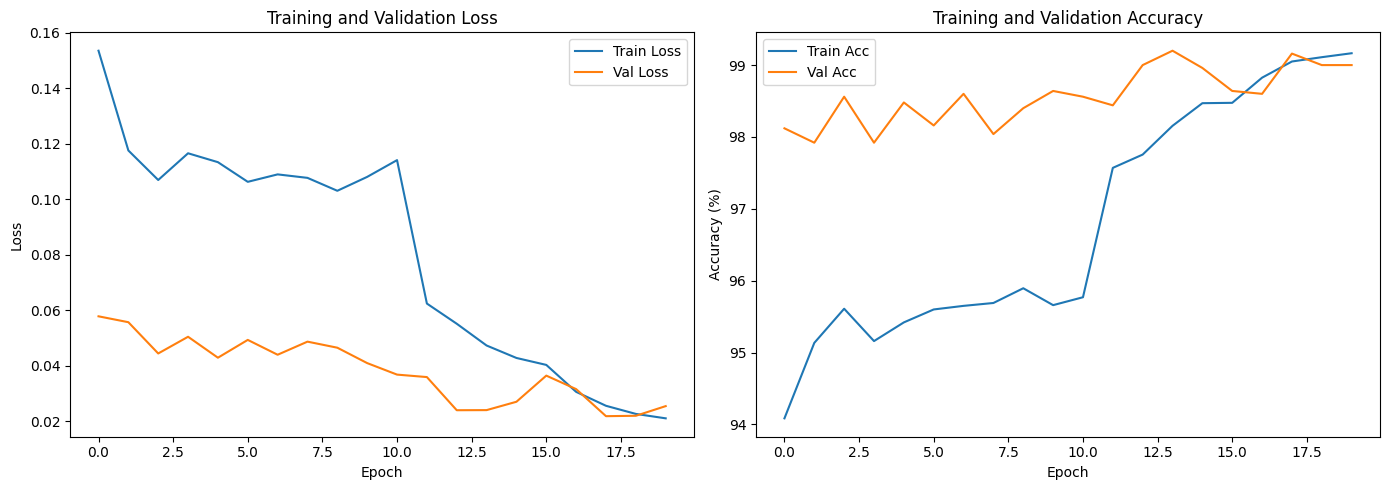

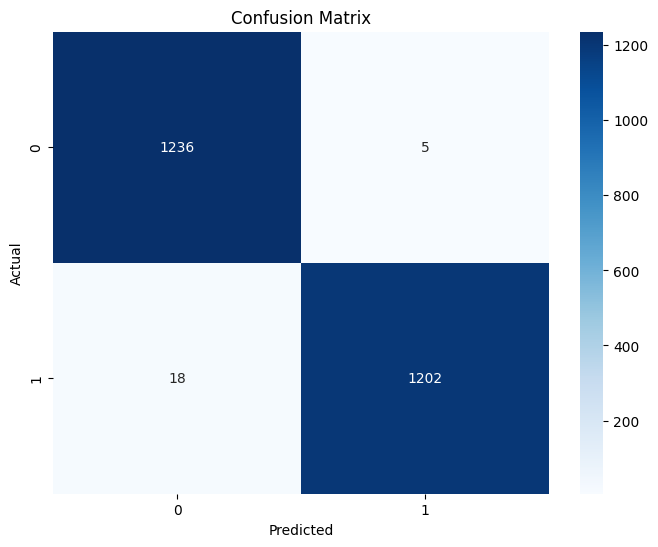

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

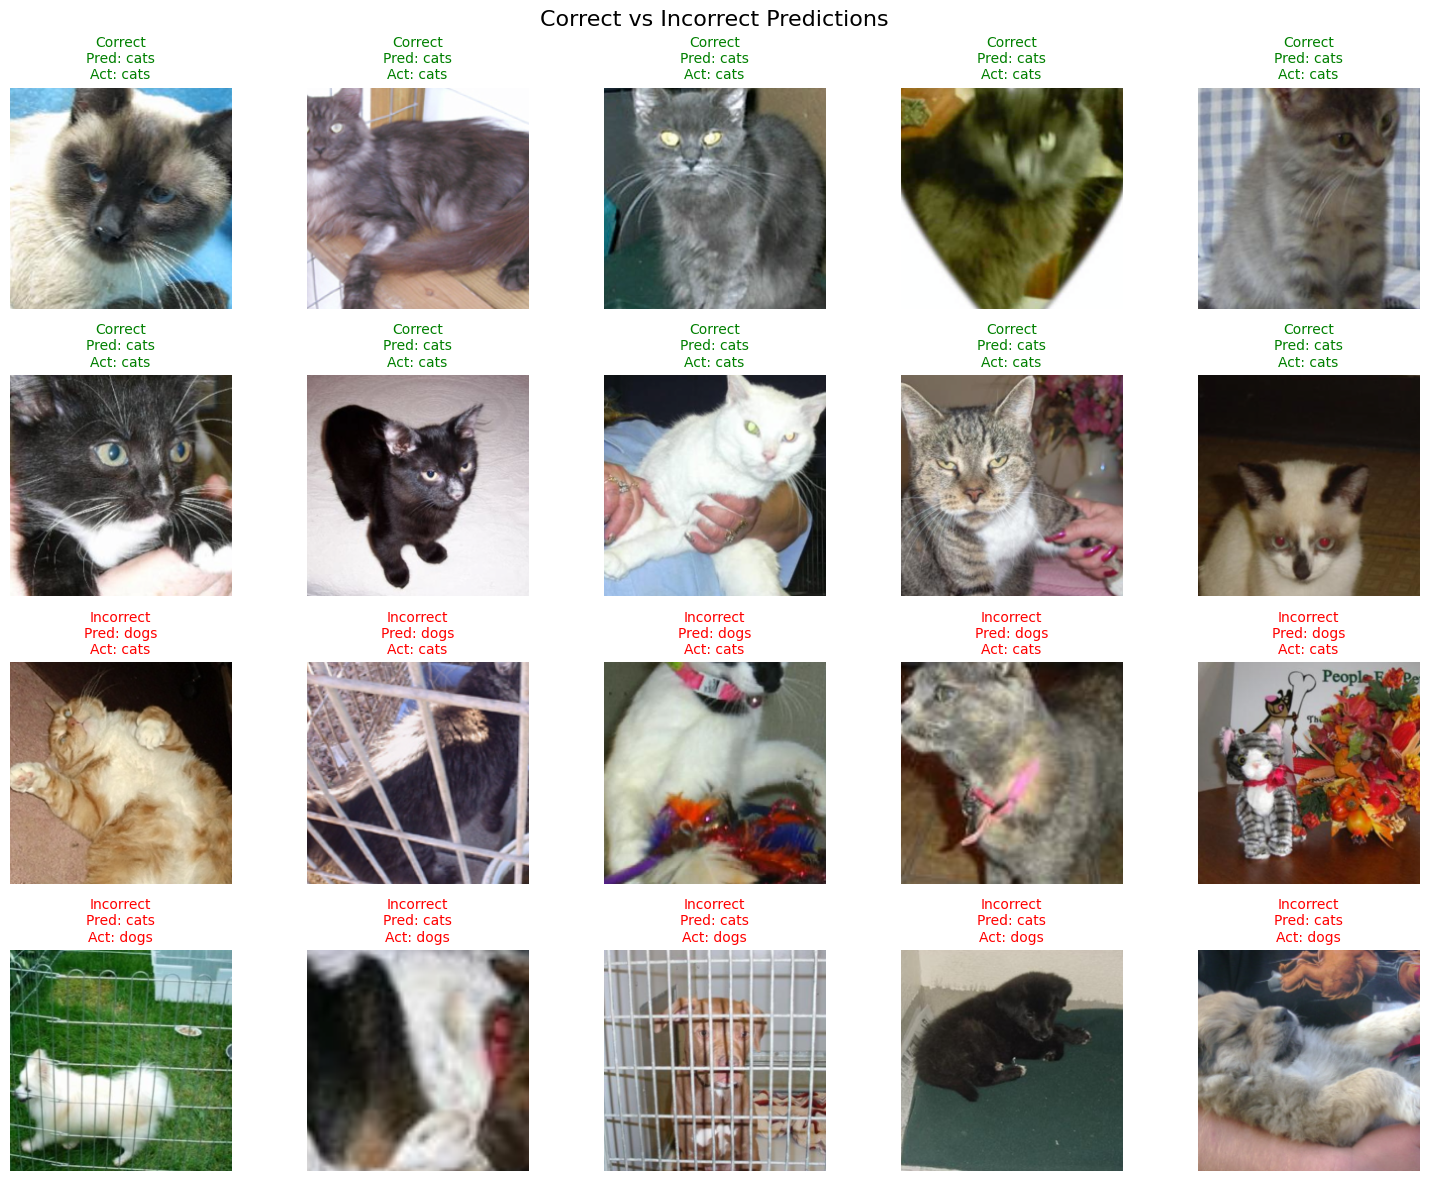

In [25]:
# Visualize Correct and Incorrect Predictions
def imshow(img, ax):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

class_names = train_dataset.classes

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Correct vs Incorrect Predictions', fontsize=16)

# Plot Correct samples (first 10)
for i, (img, pred, actual) in enumerate(correct_samples):
    row = i // 5
    col = i % 5
    if row < 4 and col < 5: # Safety check
        ax = axes[row, col]
        imshow(img, ax)
        ax.set_title(f"Correct\nPred: {class_names[pred]}\nAct: {class_names[actual]}", color='green', fontsize=10)

# Plot Incorrect samples (next 10)
for i, (img, pred, actual) in enumerate(incorrect_samples):
    row = (i + 10) // 5
    col = (i + 10) % 5
    if row < 4 and col < 5: # Safety check
        ax = axes[row, col]
        imshow(img, ax)
        ax.set_title(f"Incorrect\nPred: {class_names[pred]}\nAct: {class_names[actual]}", color='red', fontsize=10)

# Hide any unused subplots
total_plots = len(correct_samples) + len(incorrect_samples)
for i in range(total_plots, 20):
     row = i // 5
     col = i % 5
     axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('predictions_grid.png')
plt.show()